In [6]:
import matplotlib
import numpy as np
import pandas as pd
import re
import string
import tensorflow as tf

from matplotlib import pyplot as plt
from nltk.stem.porter import PorterStemmer
from pandas import DataFrame
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA, TruncatedSVD 
from sqlalchemy import create_engine

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [7]:
plt.style.use('ggplot')

matplotlib.rcParams.update({'font.size': 14})
# Simple function to prettify axes
# E.g.:
# ax = plt.subplot(111)
# simpleaxis(ax)
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# function to stem the claims
def stem(X):
    stemmer = PorterStemmer()
    stemmed_X = []

    for elem in X:
        words = elem.split()
        new_claim = [stemmer.stem(word) for word in words]
        stemmed_X.append(' '.join(new_claim))
    return np.array(stemmed_X)


def transform_text(X, meta, y, n=(1, 1), stop_words=None):
    # split dataset in a training set and a testing set
    split_ratio = 0.2
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        X, y, test_size=split_ratio, random_state=20)
    
    # run tfidf algorithm on the claims
    tfidf = TfidfVectorizer(ngram_range=n, stop_words=stop_words)
    tfidf.fit(X)
    X_train = tfidf.transform(X_train)
    X_test = tfidf.transform(X_test)

    # in case we provide metadata, we stack all the column together
    if meta != None:
        meta_train, meta_test, y_meta_train, y_meta_test = cross_validation.train_test_split(
            meta, y, test_size=split_ratio, random_state=20)  
        meta_X_train = hstack((X_train, meta_train[:,:]))
        meta_X_test = hstack((X_test, meta_test[:,:]))
        return meta_X_train, y_train, meta_X_test, y_test, tfidf
    else:
        return X_train, y_train, X_test, y_test, tfidf
        

def train_model(X_train, y_train, X_test, y_test, classifier, silent=True):
    model = classifier.fit(X_train, y_train)
    
    precision = precision_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    
    # print the different results of the algorithm 
    if not silent:
        print('Shape of the matrix is {}'.format(X_train.shape))
        print("Training accuracy is {0}".format(model.score(X_train, y_train)))
        print("Testing accuracy is {0}".format(model.score(X_test, y_test)))
        print("Precision is {0}".format(precision))
        print("Recall is {0}".format(recall))
    
    return model, model.score(X_test, y_test)

# Predicting invalidation

Loading pickled data, deduplicating patents, and running model

In [5]:
# Loading pickled data
ptab_patents = pd.read_pickle('ptab_patents.pkl')
all_cases = pd.read_pickle('ptab_cases.pkl')
all_info = pd.read_pickle('ptab_info.pkl')

# merigng the claims and the metadata
ptab_cases = all_cases[all_cases.denied.notnull()]
ptab_stats = ptab_cases.merge(all_info,suffixes = ["_ptab", "_patent"], on="patent_id")

# petitioner to lowercase and removing ponctuation
ptab_stats['petitioner_name'] = ptab_stats.petitioner_name.str.lower().str.replace('[^\w\s]','')
ptab_stats['art_unit_round']= pd.Series(np.trunc(ptab_stats.art_unit.values.astype(np.float)/10.).astype(np.int)*10)
final = ptab_patents.merge(ptab_stats, suffixes = ["_algo", "_all"], on="patent_id")

# De-duplicating patents and creating dataset
data = final.dropna(axis=0, how='any')
mask = (data.claim_text.str.len() > 1)
data = data.loc[mask]
dups = data.duplicated(subset='claim_text', keep='first')
data = data.loc[~dups]
data['art_unit_round'] = data.art_unit_round.apply(str)

# building different datasets for the algorithm
X = data.claim_text.as_matrix()
stemmed_X = stem(X) 
meta_X_all = pd.get_dummies(data[['petitioner_name', 'art_unit', 'examiner_name']]).as_matrix()
meta_X_all2 = pd.get_dummies(data[['petitioner_name', 'art_unit_round', 'examiner_name']]).as_matrix()
meta_X_pet_art = pd.get_dummies(data[['petitioner_name', 'art_unit']]).as_matrix()
meta_X_pet_art2 = pd.get_dummies(data[['petitioner_name', 'art_unit_round']]).as_matrix()
meta_X_art2 = pd.get_dummies(data[['art_unit_round']]).as_matrix()
meta_X_art = pd.get_dummies(data[['art_unit']]).as_matrix()
y = data.invalidated_all.as_matrix()

In [ ]:
# transforming the dataset to build different features
X_train, y_train, X_test, y_test, tfidf = transform_text(X, None, y)

# dataset with stemmed claims
X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed, tfidf = transform_text(stemmed_X, None, y)

# dataset with stemmed claims and art unit
X_train_art, y_train_art, X_test_art, y_test_art, tfidf = transform_text(stemmed_X, meta_X_art, y)

# dataset without stemmed claims and stop words
X_train_no_stopwords, y_train, X_test_no_stopwords, y_test, tfidf = transform_text(X, None, y, stop_words='english')

# dataset with stemmed claims, art units and petitioner names
X_train_all, y_train_all, X_test_all, y_test_all, tfidf = transform_text(stemmed_X, meta_X_pet_art, y)

In [ ]:
# default result for logistic regression
classifier = LogisticRegression(random_state=20)
model, accuracy = train_model(X_train, y_train, X_test, y_test, classifier, False)

# default results for SVC
classifier = LinearSVC(random_state=20)
train_model(X_train, y_train, X_test, y_test, classifier, False)
train_model(X_train_stemmed, y_train, X_test_stemmed, y_test, classifier, False)
train_model(X_train_art, y_train_art, X_test_art, y_test_art, classifier, False)
train_model(X_train_all, y_train_all, X_test_all, y_test_all, classifier, False)

# one result for random forest
classifier = RandomForestClassifier(n_estimators=100,
                                              min_samples_leaf=1,
                                              max_depth=32, random_state=30)
model, accuracy = train_model(X_train_stemmed, y_train, X_test_stemmed, y_test_art, classifier)

In [ ]:
# tuning the parameters for the logistic regression, SVC and ranodom forest
score = {'log': {}, 'svc': {}, 'rf': {}}

score['log']['stemmed'] = []
score['log']['normal'] = []
score['log']['art_unit'] = []
score['log']['all'] = []

name = 'log'

for C in np.arange(0.1, 5, 0.1):
    print(C)
    classifier = LogisticRegression(C=C, penalty='l2', dual=True, random_state=15)
    model, accuracy = train_model(X_train, y_train, X_test, y_test, classifier)
    score[name]['normal'].append(accuracy)
    
    model, accuracy = train_model(X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed, classifier)
    score[name]['stemmed'].append(accuracy)
    
    model, accuracy = train_model(X_train_art, y_train_art, X_test_art, y_test_art, classifier)
    score[name]['art_unit'].append(accuracy)
    
    model, accuracy = train_model(X_train_all, y_train_all, X_test_all, y_test_all, classifier)
    score[name]['all'].append(accuracy)
    
    
score['svc']['stemmed'] = []
score['svc']['normal'] = []
score['svc']['art_unit'] = []
score['svc']['all'] = []
print('SVC')
name = 'svc'
for C in np.arange(0.1, 10, 0.05):
    if (C % 1) == 0:
        print(C)
    classifier = LinearSVC(C=C)
    model, accuracy = train_model(X_train, y_train, X_test, y_test, classifier)
    score[name]['normal'].append(accuracy)

    model, accuracy = train_model(X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed, classifier)
    score[name]['stemmed'].append(accuracy)

    model, accuracy = train_model(X_train_art, y_train_art, X_test_art, y_test_art, classifier)
    score[name]['art_unit'].append(accuracy)

    model, accuracy = train_model(X_train_all, y_train_all, X_test_all, y_test_all, classifier)
    score[name]['all'].append(accuracy)

score['rf'] = {}
score['rf']['stemmed'] = []
score['rf']['normal'] = []
score['rf']['art_unit'] = []
score['rf']['all'] = []
print('Random Forest')
name = 'rf'
for C in np.arange(10, 40, 2):
    print(C)
    classifier = RandomForestClassifier(n_estimators=100,
                                              min_samples_leaf=1,
                                              max_depth=C,
                                       random_state=30)
    model, accuracy = train_model(X_train, y_train, X_test, y_test, classifier)
    score[name]['normal'].append(accuracy)

    model, accuracy = train_model(X_train_stemmed, y_train_stemmed, X_test_stemmed, y_test_stemmed, classifier)
    score[name]['stemmed'].append(accuracy)

    model, accuracy = train_model(X_train_art, y_train_art, X_test_art, y_test_art, classifier)
    score[name]['art_unit'].append(accuracy)

    model, accuracy = train_model(X_train_all, y_train_all, X_test_all, y_test_all, classifier)
    score[name]['all'].append(accuracy)

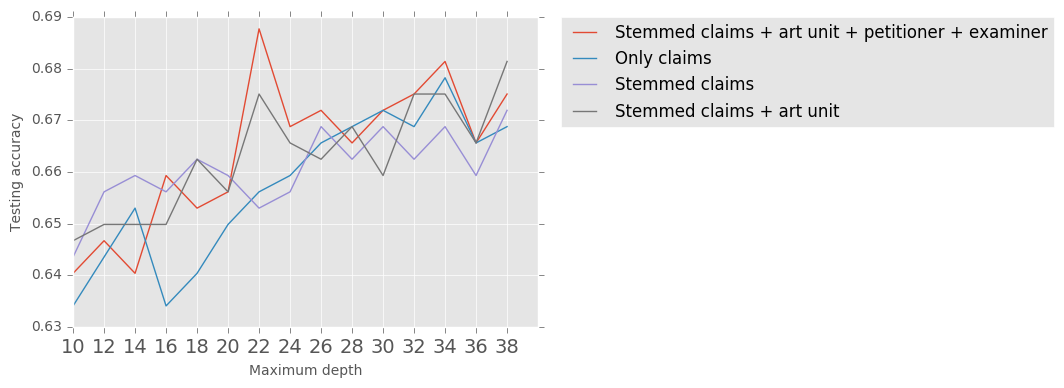

In [23]:
# figure of the results obtained for the tree
# change name and range for the figure of other models
name = 'rf'
xrange = np.arange(10, 40, 2)
np.arange(1, 20, 1)
plt.plot(xrange, score[name]['all'], label='Stemmed claims + art unit + petitioner + examiner')
plt.plot(xrange, score[name]['normal'], label='Only claims')
plt.plot(xrange, score[name]['stemmed'], label='Stemmed claims')
plt.plot(xrange, score[name]['art_unit'], label='Stemmed claims + art unit')
plt.xticks(np.arange(10, 40, 2))
plt.yticks(fontsize=10)
plt.xlabel('Maximum depth', fontsize=10)
plt.ylabel('Testing accuracy', fontsize=10)
# plt.title('Testing accuracy for a random forest of 100 trees depending on the minimum number of  (max depth=36)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)

# N-grams model

In [ ]:
# list to store the accuracy of the different models
score_svc_quad = []
score_svc_tri = []
score_svc_bi = []

# test algorithm for n-grams model (n=2, 3, 4) on stemmed claims and with or without art unit
bi_X_train_stemmed, y_train_stemmed, bi_X_test_stemmed, y_test_stemmed, tfidf = transform_text(stemmed_X, None, y, (1, 2))
tri_X_train_stemmed, y_train_stemmed, tri_X_test_stemmed, y_test_stemmed, tfidf = transform_text(stemmed_X, None, y, (1, 3))
quad_X_train_stemmed, y_train_stemmed, quad_X_test_stemmed, quad_test_stemmed, tfidf = transform_text(stemmed_X, None, y, (1, 4))

# to get the algorithm running with the art units, simply uncomment the lines below
# bi_X_train_stemmed, y_train_stemmed, bi_X_test_stemmed, y_test_stemmed, tfidf = transform_text(stemmed_X, meta_X_art, y, (1, 2))
# tri_X_train_stemmed, y_train_stemmed, tri_X_test_stemmed, y_test_stemmed, tfidf = transform_text(stemmed_X, meta_X_art, y, (1, 3))
# quad_X_train_stemmed, y_train_stemmed, quad_X_test_stemmed, quad_test_stemmed, tfidf = transform_text(
#    stemmed_X, meta_X_art, y, (1, 4))

# accuracy of the different models (using SVC) and by tuning the regularization parameter
for C in np.arange(0.1, 10, 0.1):
    print(C)
    classifier = LinearSVC(C=C)
    model, accuracy = train_model(quad_X_train_stemmed, y_train, quad_X_test_stemmed, y_test, classifier)
    score_svc_quad.append(accuracy)
    
    model, accuracy = train_model(bi_X_train_stemmed, y_train, bi_X_test_stemmed, y_test, classifier)
    score_svc_bi.append(accuracy)
    
    model, accuracy = train_model(tri_X_train_stemmed, y_train, tri_X_test_stemmed, y_test, classifier)
    score_svc_tri.append(accuracy)

    
# doing the same but for the logistic regression 
score_log_quad = []
score_log_tri = []
score_log_bi = []
score_log_uni = []

for C in np.arange(0.1, 10, 0.2):
    print(C)
    classifier = LogisticRegression(C=C, penalty='l2', dual=True, random_state=15)
    model, accuracy = train_model(quad_X_train_stemmed, y_train, quad_X_test_stemmed, y_test, classifier)
    score_log_quad.append(accuracy)
    
    model, accuracy = train_model(bi_X_train_stemmed, y_train, bi_X_test_stemmed, y_test, classifier)
    score_log_bi.append(accuracy)
    
    model, accuracy = train_model(tri_X_train_stemmed, y_train, tri_X_test_stemmed, y_test, classifier)
    score_log_tri.append(accuracy)    
    
    model, accuracy = train_model(X_train_stemmed, y_train, X_test_stemmed, y_test, classifier)
    score_log_uni.append(accuracy)    

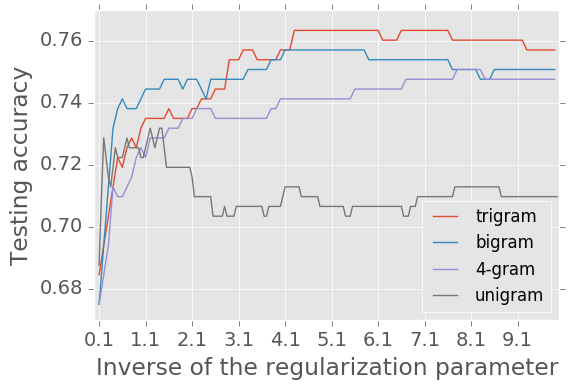

In [16]:
# figure of the results for the SVC
plt.plot(np.arange(0.1, 10, 0.1), score_svc_tri, label='trigram')
plt.plot(np.arange(0.1, 10, 0.1), score_svc_bi, label='bigram')
plt.plot(np.arange(0.1, 10, 0.1), score_svc_quad, label='4-gram')
plt.plot(np.arange(0.1, 10, 0.05), score['svc']['stemmed'], label='unigram')
plt.legend(loc=4, fontsize=12)
plt.xticks(np.arange(0.1, 10, 1))
plt.xlabel('Inverse of the regularization parameter')
plt.ylabel('Testing accuracy')

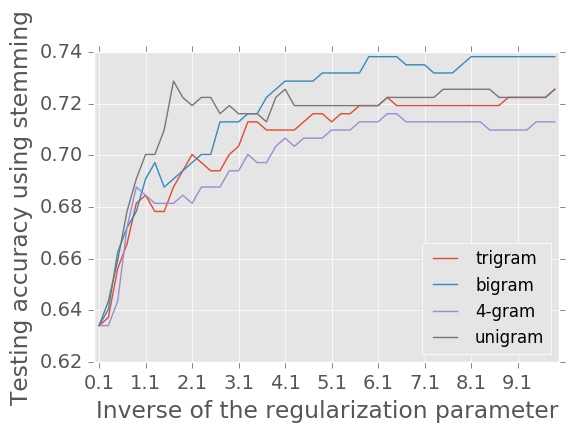

In [19]:
# figure of the results for the logistic regression
plt.plot(np.arange(0.1, 10, 0.2), score_log_tri, label='trigram')
plt.plot(np.arange(0.1, 10, 0.2), score_log_bi, label='bigram')
plt.plot(np.arange(0.1, 10, 0.2), score_log_quad, label='4-gram')
plt.plot(np.arange(0.1, 10, 0.2), score_log_uni, label='unigram')
plt.legend(loc=4, fontsize=12)
plt.xticks(np.arange(0.1, 10, 1))
plt.xlabel('Inverse of the regularization parameter')
plt.ylabel('Testing accuracy using stemming')

# Feature Importance

In [ ]:
# run random forest in order to get the feature importance
classifier = RandomForestClassifier(n_estimators=100,
                                              min_samples_leaf=1,
                                              max_depth=32, random_state=30)
model, accuracy = train_model(X_train_stemmed, y_train, X_test_stemmed, y_test_art, classifier)
accuracy

In [369]:
# get the most important words from the random forest
np.argsort(model.feature_importances_)[-10:]
list_word = []
for feature in np.argsort(model.feature_importances_)[-10:]:
    # get the word that corresponds to the most important features
    for word in tfidf.vocabulary_:
        if tfidf.vocabulary_[word] == feature:
            list_word.append(word)

list_word

array([  0.00000000e+00,   1.31650523e-04,   0.00000000e+00, ...,
         0.00000000e+00,   0.00000000e+00,   2.91014402e-05])

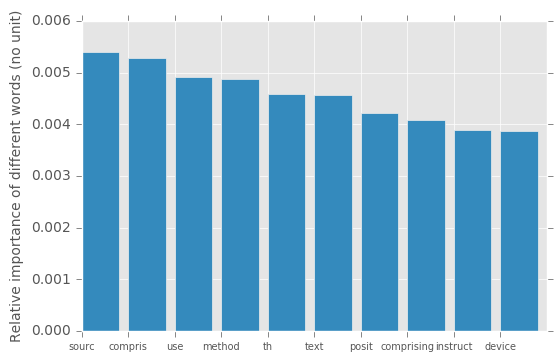

In [375]:
# plot the distribution of the most important words
plt.bar(range(10), np.sort(model.feature_importances_)[-10:][::-1])
plt.xticks(range(10), list_word, fontsize=7)
plt.ylabel('Relative importance of different words (no unit)', fontsize=10)

# Dimensionality reduction (PCA...) 

In [ ]:
# running pca with stemmed claims and 1000 components
tfidf = TfidfVectorizer()
tfidf.fit(stemmed_X)
tfidf_x_stemmed = tfidf.transform(stemmed_X)

pca  = PCA(n_components=1000)
pca.fit(tfidf_x_stemmed.toarray())
pca_stemmed_train = pca.transform(X_train_stemmed.toarray())
pca_stemmed_test = pca.transform(X_test_stemmed.toarray())

classifier = LinearSVC(C=1.7)
model, accuracy = train_model(pca_stemmed_train, y_train, pca_stemmed_test, y_test, classifier)
print(accuracy)

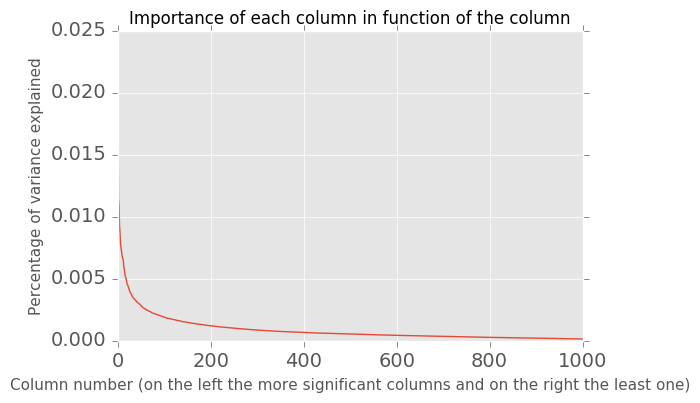

In [28]:
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Percentage of variance explained', fontsize=11)
plt.xlabel('Column number (on the left the more significant columns and on the right the least one)', fontsize=11)
plt.title('Importance of each column in function of the column', fontsize=12)

In [ ]:
pca_score_log = []

# get accuracy for SVC and Logistic regression using only the n
# components that comes from PCA (change range() to see the effect
# of n in the accuracy)
for n in range(5000, 12000, 1000):
    print(n)
    pca = PCA(n_components=n)
    pca.fit(tfidf_x_stemmed.toarray())
    pca_stemmed_train = pca.transform(X_train_stemmed.toarray())
    pca_stemmed_test = pca.transform(X_test_stemmed.toarray())
    
    classifier = LogisticRegression(C=1.7, penalty='l2', dual=True, random_state=15)
    model, accuracy = train_model(pca_stemmed_train, y_train, pca_stemmed_test, y_test, classifier)
    pca_score_log.append(accuracy)
    
pca_score_svc = []

for n in range(1, 12000, 1000):
    pca = PCA(n_components=n)
    pca.fit(tfidf_x_stemmed.toarray())
    pca_stemmed_train = pca.transform(X_train_stemmed.toarray())
    pca_stemmed_test = pca.transform(X_test_stemmed.toarray())
    
    classifier = LinearSVC(C=4.3)
    model, accuracy = train_model(pca_stemmed_train, y_train, pca_stemmed_test, y_test, classifier)
    pca_score_svc.append(accuracy)
    print(accuracy)

In [ ]:
plt.plot(range(100, 4000, 100), pca_score_svc, label='SVC (C=1.2)')
plt.plot(range(100, 4000, 100), pca_score_log, label='Logistic Regression (C=1.7)')
plt.xticks(range(100, 4000, 400))
plt.yticks(fontsize=10)
plt.xlabel('Number of components', fontsize=10)
plt.ylabel('Testing accuracy for stemmed claims only', fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)

# Output of a model into a pickle (for the website)

In [19]:
pickle.dump(model, open('invalidation_model.pkl', 'wb'))
pickle.dump(tfidf, open('invalidation_tfidf.pkl', 'wb'))